In [0]:
!pip3 install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
import pandas as pd


def collect_csv_data_via_gd(link: str, filenm: str) -> pd.core.frame.DataFrame:
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    fluff, id = link.split('=')
    downloader = drive.CreateFile({'id':id})
    downloader.GetContentFile(filenm)  
    return pd.read_csv(filenm)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import factorial
from scipy import stats
import warnings

warnings.simplefilter('ignore')

%matplotlib inline

В учебных целях в данном задании запрещено использовать готовые реализации линейной регрессии (например, из пакета $\verb|scikit-learn|$).

# Задача №1

Загрузите данные из набора $\verb|Forest Fires|$ (файл $\verb|forestfires.csv|$) о лесных пожарах в Португалии. Задача состоит в том, чтобы с помощью линейной регрессии научиться предсказывать координату area (площадь пожара) в виде линейной комбинации других данных.

Чтобы работать с числовыми координатами, нечисловые координаты ($\verb|month|$, $\verb|day|$) нужно перевести в числовые. Для простоты можно заменить координату month на индикатор летнего сезона, а координату day не использовать вообще. По желанию можно сделать преобразование другим способом. Также добавьте координату, тождественно равную единице (вес при этой координате  интерпретируется как сдвиг).

Разбейте выборку на две части в соотношении $7:3$ (перемешав её с помощью $\verb|random.shuffle|$). По первой части постройте регрессионную модель. Примените модель ко второй части выборки и посчитайте по ней среднеквадратичную ошибку.

Для переменной area выполните преобразование $f(x) = ln(x+c)$ и постройте для нее новую регрессионную модель. Посчитайте среднеквадратичную ошибку для преобразованных значений. При каком $c$ предсказания получаются лучше всего? 

При выбранном $c$ сделайте разбиение выборки в соотношении $7:3$ разными способами (перемешивая каждый раз). Найдите способ оценить разброс качества от разбиения. Сильно ли меняется качество? Сделайте выводы.

# Решение

Загрузим данные и выполним преобразования и сделаем копию для вспомогательных расчетов: 

In [0]:
df_data = collect_csv_data_via_gd(
    link="https://drive.google.com/open?id=16biq--Fyj66FCIXJoLAPFM1iuhoDqHFd",
    filenm="forestfires.csv")\
    .drop("day", axis=1)

df_data.month = df_data.month.apply(
    lambda month: int(month in ['jun', 'jul', 'aug']))

df_data["shift"] = 1.0

df_data_copy = df_data.copy()

Напишем функцию вычисляющую $\verb|MSE|$:

In [0]:
def compute_mean_squared_error(predicted, actual):
    return np.square(np.subtract(predicted, actual)).mean()

Следующий класс $\verb|ForestFiresLinReg|$ описывает линейную регресионную модель в нашей задаче.  


*   $\verb|compute_mean_squared_estimator|$ - вычисляет оценку наименьших квадратов
*   $\verb|split_data|$ - разбить датасет на данные для тестирования и предсказания
*   $\verb|extract_basis|$ - выделить базис из датасета
*   $\verb|extract_values|$ - выделить сами значения из датасета
*   $\verb|test_prediction|$ - обучиться на части данных и выполнить предсказание на остатке



In [0]:
class ForestFiresLinReg:

    def __init__(self, **kwargs):
        self.transform = np.vectorize(
            kwargs.get("transform", lambda x: x))
        self.transform_inv = np.vectorize(
            kwargs.get("transform_inv", lambda x: x))
            
    @staticmethod
    def compute_mean_squared_estimator(values, basis):
        return np.linalg.inv(basis.T @ basis) @ basis.T @ values
    
    @staticmethod
    def split_data(df: pd.core.frame.DataFrame, split_factor: float)\
      -> (pd.core.frame.DataFrame, pd.core.frame.DataFrame):
        assert 0. < split_factor < 1., "Incorrect split factor"
        items_cnt = len(df)
        to_train_cnt = int(np.ceil(items_cnt * split_factor))
        return df[:to_train_cnt], df[to_train_cnt:]

    @staticmethod
    def extract_basis(df: pd.core.frame.DataFrame)\
      -> pd.core.frame.DataFrame:
        return df.drop(labels=["area"], axis=1)

    @staticmethod
    def extract_values(df: pd.core.frame.DataFrame)\
      -> pd.core.frame.DataFrame:
        return df.area

    def test_prediction(self, df: pd.core.frame.DataFrame, split_factor: float)\
      -> pd.core.frame.DataFrame:
        df.area = self.transform(df.area)
        to_train, to_predict = self.split_data(df, split_factor)
        theta_est = self.compute_mean_squared_estimator(
            self.extract_values(to_train), 
            self.extract_basis(to_train)
        )
        predicted_areas = np.dot(self.extract_basis(to_predict), theta_est)
        actual_areas = self.extract_values(to_predict)
        return pd.DataFrame(data={
            "predicted": self.transform_inv(predicted_areas),
            "actual"   : self.transform_inv(actual_areas) 
        })

Напишем функцию для тестирования работы линейной регресионной модели c $log-$трансформацией при фиксированном значении $c$:

In [0]:
def test_log_transform(c_param: float) -> float:
    loglinreg_model = ForestFiresLinReg(
        transform=lambda x: np.log(x + c_param),
        transform_inv=lambda x: np.exp(x) - c_param)
    df_test = loglinreg_model.test_prediction(df_data_copy.copy(), 0.7)
    return compute_mean_squared_error(
        predicted=df_test.predicted,
        actual=df_test.actual)

vtest_log_transform = np.vectorize(test_log_transform)

И для простой линейной регрессионной модели, т.е. без дополнительной трансформации данных:

In [0]:
def test_standart() -> float:
    df_test = ForestFiresLinReg().test_prediction(df_data_copy.copy(), 0.7)
    return compute_mean_squared_error(
        predicted=df_test.predicted,
        actual=df_test.actual)

Для $1\leq c\leq 1000$ с шагом $1$ для фиксированного порядка датасета найдем оптимально значение $\verb|c|$, т.е. при каком значении $\verb|c|$ $\verb|MSE|$ принимает наименьшее значение.  
Выполним всего 10 серий таких тестов, перемешивая данные на каждой серии.  
В дополнение, на каждой серии посчитаем $\verb|MSE|$ для линейной регрессионной модели без дополнительных преобразований данных.

Test №1:
    	* loglinreg_model.MSE(83) = 4578.087574373634
    	* linreg_model.MSE = 4724.1332614232
Test №2:
    	* loglinreg_model.MSE(21) = 507.2862020056817
    	* linreg_model.MSE = 807.4596508490382
Test №3:
    	* loglinreg_model.MSE(92) = 1426.4265668726123
    	* linreg_model.MSE = 1594.1685266102922
Test №4:
    	* loglinreg_model.MSE(148) = 1636.2294541922138
    	* linreg_model.MSE = 1743.462407102731
Test №5:
    	* loglinreg_model.MSE(9) = 714.361622136963
    	* linreg_model.MSE = 1095.598482307715
Test №6:
    	* loglinreg_model.MSE(143) = 559.1309933870166
    	* linreg_model.MSE = 611.3466290991527
Test №7:
    	* loglinreg_model.MSE(1000) = 8502.825665807215
    	* linreg_model.MSE = 8486.905418167431
Test №8:
    	* loglinreg_model.MSE(1000) = 12069.047600240208
    	* linreg_model.MSE = 12064.966384596317
Test №9:
    	* loglinreg_model.MSE(42) = 557.4295468413637
    	* linreg_model.MSE = 699.3240950102736
Test №10:
    	* loglinreg_model.MSE(62) = 931.3903231061

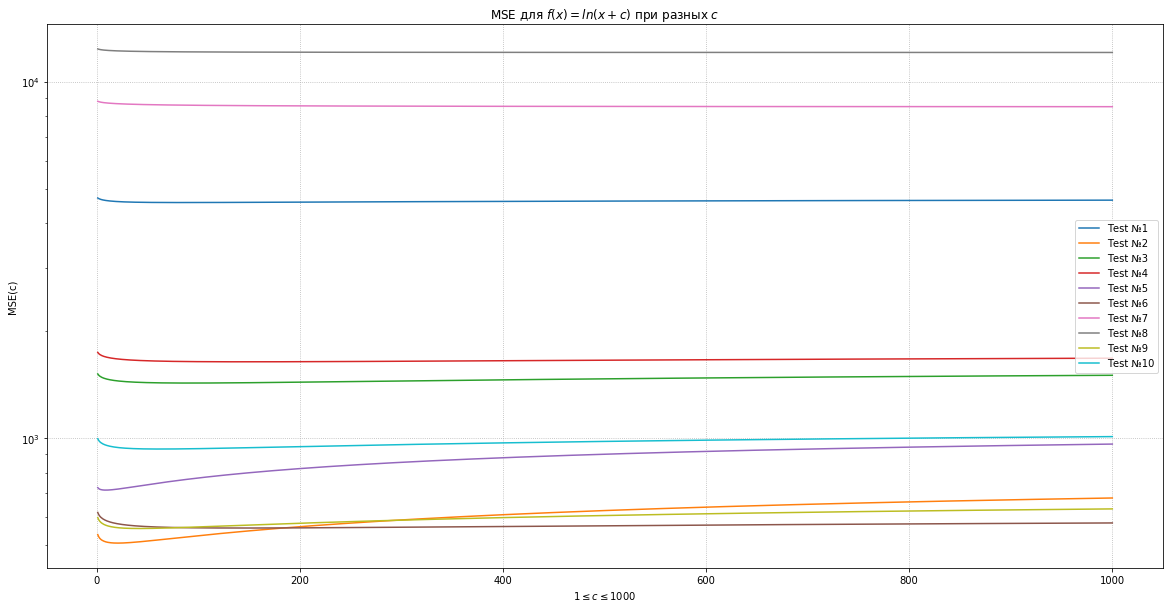

In [9]:
c_vector = np.linspace(1, 1000, num=10**3)
plt.figure(figsize=(20, 10))
plt.title('MSE для $f(x) = ln(x+c)$ при разных $c$')
plt.xlabel('$1\leq c\leq 1000$')
plt.ylabel('MSE(c)')
plt.yscale('log')
for test in range(10):
    series = vtest_log_transform(c_vector)
    c_min = np.argmin(series)
    print(f"""Test №{test+1}:
    \t* loglinreg_model.MSE({c_min+1}) = {series[c_min]}
    \t* linreg_model.MSE = {test_standart()}""")
    plt.plot(c_vector, series, label=f"Test №{test+1}")
    df_data_copy = df_data_copy\
      .sample(frac=1)\
      .reset_index(drop=True)
plt.grid(ls=':')
plt.legend()
plt.show()

Как видим, невозможно предсказать, что при увеличении/уменьшении параметра $\verb|c|$, мы получим меньшее значение $\verb|MSE(c)|$.  

Также важно заметить, что на каждой серии при равных $\verb|c|$ значения $\verb|MSE(c)|$ разнятся. Причем само $\verb|MSE(c)|$ может отличаться на несколько порядков в некоторых случаях, что при равных $\verb|c|$, что при "оптимальных" $\verb|c|$. Однако, это вполне закономерно, т.к. на разных подчастях датасета модель строится разная, метод оценки наименьших квадратов дает разные значения. 


Более того, при перемешиваниии мы предсказываем часть прошлое по части будущему и наоборот, что довольно странно.

Также по приложенному графику сложно судить о том, о поведении функции $\verb|MSE(c)|$. Все потому что $\verb|MSE(c)|$ также является функцией от данных, а на каждой серии, аргумент $-$ данные $-$ разные из-за перемешивания.  


Отдельно отметим, что в случае, когда линейная регрессионная модель с $log-$трансформацией даёт минимальное значение $\verb|MSE|$ при различных $\verb|c|$ на разных данных, в том числе и при $\verb|c|=1000$. Это объясняется, тем, что значения $\verb|c|$ мы берем из ограниченного отрезка, а "оптимальное" $\verb|c|$ может "лежать дальше" $10^3$. Однако, при найденном оптимальном $\verb|c|<10^3$ среднеквадратичная ошибка меньше в моделе с $log-$трансформацией, чем в простой.

# Вывод №1

Таким образом данную задачу решать методом линейной регрессии не совсем оправдано, так как этот метод дает очень большую ошибку на тестовых данных при случайном сплите. Возможно, если брать данные в хронолигическом порядке данный метод отработает лучше, но данные не полные, т.к. в датасете нет поля "год". Из условия не ясно: данные за один год или за несколько лет. В случае, когда данные за один год, разбиение $7:3$ не годится при упорядовачивании в хронологическом порядке по понятным причинам.  
Результаты экспериментов показывают, что модель $log-$трансформацией даёт меньшую среднеквадратичную ошибку, исключая те случаи, когда $\verb|c|$ не лежит в $[1;1000]$.

# Задача №2

Пусть $$X_i = \beta_1+i\beta_2+\varepsilon_0+\ldots+\varepsilon_i,\, i= 0, 1, \ldots, n$$ $-$ расстояния, которое проехал трамвай за $i$ секунд по показанию датчика. Здесь $\beta_1$ $-$ начальное расстояние, $\beta_2$ $-$ скорость трамвая, $\varepsilon_0$ $-$ ошибка начального показания датчика. Трамвай едет с постоянной скоростью, и через каждую секунду датчик фиксирует расстояние, которое проехал трамвай. Отсчет времени идет от предыдущего замера, причем отсчет происходит с ошибкой. Для $i = 1, \ldots, n$ величина $\varepsilon_i$ есть ошибка приращения расстояния, то есть $\varepsilon_i = \varepsilon_i^t \beta_2,$ где $\varepsilon_i^t$ $-$ ошибка отсчета времени. Все ошибки $\varepsilon_i$ независимы и распределены по закону $\mathcal{N}(0, \sigma^2)$. 

Сведите задачу к линейной модели и найдите оценки наименьших квадратов для начального расстояния $\beta_1$ и скорости $\beta_2,$ а также несмещенную оценку для $\sigma^2,$ из которой выразите оценку дисперсии отсчета времени. 

Данные возьмите из файла $\verb|Regression.csv|$. Сделайте выводы.

# Решение

Сведем решение к линейной модели. Достаточно рассмотреть разности вида: $$Y_{i} = X_{i+1} - X_i = \beta_{2} + \varepsilon_{i}$$ для $\forall{i} > 0.$  
Более того, положим $Y_{0} = X_{0} = \beta_{1} + \varepsilon_{0}.$ Значение $Y_i$ это расстояние, которое проезжает трамвай за $i$-ую секунду.  
Найдем оценку коэффициентов линейной регрессии методом наименьших квадратов:  
$$\hat{\theta} = (Z^{T}\cdot Z)^{-1}\cdot Z^T\cdot Y = 
\begin{pmatrix} 
  \hat{\beta_{1}} \\
  \hat{\beta_{2}} 
\end{pmatrix}$$  
где:  
$Y$ - вектoр данных,  
$Z=
\begin{pmatrix} 
1 \ 0 \\ 0 \ 1 \\ ... \\ 0 \ 1 
\end{pmatrix}.$    

Решением является:  
$\hat{\beta_{1}} = Y_{0},$    
$\hat{\beta_{2}} = \overline{\textbf{Y}^{'}}$, где $\textbf{Y}^{'}=\{Y_{i}|i=\overline{1,n}\}.$    

Несмещенная оценка $\sigma^{2}:$  
$$\hat{\sigma^2} = \frac{1}{n - k}||Y - Z\cdot\hat{\theta}||^2 = $$  
$$= \frac{1}{n - 2}\cdot\sum_{i = 1}^n{(Y_i - \overline{Y^{'}})^2}=\frac{n}{n-2}\cdot s^2(Y^{'})$$    

Дисперсия отсчета времени равна: $\hat{\sigma^{2}_{t}}=\frac{\hat{\sigma^2}}{\hat{\beta_{2}}^{2}}.$

Загрузим данные:

In [0]:
df_data = collect_csv_data_via_gd(
    link="https://drive.google.com/open?id=1ODAEoNo-WgheJ7bnwKmUErajqDPWW-tU",
    filenm="regression.csv")

Преобразуем данные из $\verb|pandas.DataFrame|$ в $\verb|numpy.array|$ c учетом специфики считывания через $\verb|pandas|$ входных данных.

In [0]:
x_rvs = np.append(
    [np.float64(df_data.columns[0])],
    df_data.iloc[:,0:].values.flatten()
)

Согласно теоретическим выладкам выше, построим линейную регрессионную модель:

In [0]:
y_rvs = x_rvs - np.append([0.], x_rvs[:-1])

Найдем оценки наименьших квадратов:

In [0]:
beta_est = (y_rvs[0], np.mean(y_rvs[1:]))
n = y_rvs.shape[0] - 1
sigma_sq_est = (n / (n - 2)) * stats.moment(y_rvs[1:], moment=2)
sigma_sq_t_est = sigma_sq_est / (beta_est[1]**2)

для начального расстояния $\beta_1$ и скорости $\beta_2$

In [14]:
beta_est

(82.0053, 11.970782982982984)

несмещенной оценки $\sigma^2$

In [15]:
sigma_sq_est

1.5267747059886199

дисперсии отсчета времени $\hat{\sigma^{2}_{t}}$

In [16]:
sigma_sq_t_est

0.01065442069716351

# Вывод №2

Дисперсия времени мала, следовательно показания датчика довольно точные. Линейная модель дает хорошее приближение, т.е. это подтверждает, что полученные оценки для $\hat{\beta_{1}}$, $\hat{\beta_{2}}$, $\hat{\sigma^{2}}$ и $\hat{\sigma_{t}^{2}}$ были найдены довольно точно. 